In [ ]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
import seaborn as sns
from pymongo import MongoClient
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px
import datetime as dt
from operator import attrgetter
from sklearn.cluster import KMeans
import warnings
import os
sns.set()
# importing DateTime module to convert extracted dates
import datetime as dt

In [ ]:
db_name = "Processed_Thrifty_Database"
host = "capstone-cosmos-db.mongo.cosmos.azure.com"
port = 10255
username = "capstone-cosmos-db"
password = "BuYmUjcc9LwFDN2PdVNuUudZTG5ABlxPoZgdIoRlrugcfiF5Rm15REQOJL1dspgH28NeeJI5dOeMCwzqRRrCvg=="
args = "ssl=true&retrywrites=false&ssl_cert_reqs=CERT_NONE"

In [ ]:
connection_uri = f"mongodb://{username}:{password}@{host}:{port}/{db_name}?{args}"
client = MongoClient(connection_uri)
 
db = client[db_name]
collection = db['Customer_Segmentation']

In [ ]:
data= pd.DataFrame(list(collection.find()))
data.head(2)

,_id,Customer_Id,Transaction_Date,Item_Id,Quantity_Purchased,Sales_Person_Id,User_Product_Review,Purchased_From,Product_Discovery_Info,Showroom_Id,Customer_Ratings,Transaction_Year,Transaction_Month,Transaction_Time,Transaction_Hour,Transaction_Quarter,Transaction_Day,Transaction_Day_Type,Holiday,Holiday_Name,Item_Name,Item_Price,Amount_Spent,Name,Gender,Birthdate,Address,Dt_Customer,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Current_Age,Town,Latitude,Longitude,State,Transaction_Age
0,6094edbae1a88135b12d145c,1680,2020-09-28 03:03:24,3001,7,81,good,online,customer,-1,4,2020,September,05:03:24,5,3,Monday,Weekday,No,None,dresses,100,700,Herr Jan Geisel B.A.,F,1917-04-25,Lindaugasse 17\n49311 Schwerin,2013-04-28,74,0,0,0,50.0,Schwerin,53.62883,11.414804,Mecklenburg-Vorpommern,50.0
1,6094edbbe1a88135b12dcdaf,1680,2020-06-12 13:51:47,3001,5,78,not that good,online,twitter,-1,2,2020,June,15:51:47,15,2,Friday,Weekday,No,None,dresses,100,500,Herr Jan Geisel B.A.,F,1917-04-25,Lindaugasse 17\n49311 Schwerin,2013-04-28,74,0,0,0,50.0,Schwerin,53.62883,11.414804,Mecklenburg-Vorpommern,50.0


In [ ]:
df=data.drop(['AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5','Latitude','Longitude','_id','Birthdate','Dt_Customer'], axis=1)
df.head(2)

,Customer_Id,Transaction_Date,Item_Id,Quantity_Purchased,Sales_Person_Id,User_Product_Review,Purchased_From,Product_Discovery_Info,Showroom_Id,Customer_Ratings,Transaction_Year,Transaction_Month,Transaction_Time,Transaction_Hour,Transaction_Quarter,Transaction_Day,Transaction_Day_Type,Holiday,Holiday_Name,Item_Name,Item_Price,Amount_Spent,Name,Gender,Address,Recency,Current_Age,Town,State,Transaction_Age
0,1680,2020-09-28 03:03:24,3001,7,81,good,online,customer,-1,4,2020,September,05:03:24,5,3,Monday,Weekday,No,None,dresses,100,700,Herr Jan Geisel B.A.,F,Lindaugasse 17\n49311 Schwerin,74,50.0,Schwerin,Mecklenburg-Vorpommern,50.0
1,1680,2020-06-12 13:51:47,3001,5,78,not that good,online,twitter,-1,2,2020,June,15:51:47,15,2,Friday,Weekday,No,None,dresses,100,500,Herr Jan Geisel B.A.,F,Lindaugasse 17\n49311 Schwerin,74,50.0,Schwerin,Mecklenburg-Vorpommern,50.0


In [ ]:
df.groupby('State')['Customer_Id'].nunique().reset_index()

,State,Customer_Id
0,Baden-Württemberg,169
1,Bayern,500
2,Berlin,6
3,Brandenburg,186
4,Bremen,3
5,Hamburg,4
6,Hessen,87
7,Mecklenburg-Vorpommern,169
8,Niedersachsen,196
9,Nordrhein-Westfalen,198


In [ ]:
df.describe()

,Customer_Id,Item_Id,Quantity_Purchased,Sales_Person_Id,Showroom_Id,Customer_Ratings,Transaction_Hour,Item_Price,Amount_Spent,Recency,Current_Age,Transaction_Age
count,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000,954012.000000
mean,1119.715599,3010.994573,5.501564,44.999375,4.511045,3.000055,11.500179,120.508049,662.594129,49.119502,50.707011,50.686351
std,646.829869,6.054429,2.873100,26.276440,6.971498,1.581199,6.921197,77.148732,590.206053,28.964527,25.577237,25.908230
min,0.000000,3001.000000,1.000000,0.000000,-1.000000,1.000000,0.000000,15.000000,15.000000,0.000000,2.000000,2.000000
25%,559.000000,3006.000000,3.000000,22.000000,-1.000000,1.000000,6.000000,70.000000,220.000000,24.000000,31.000000,31.000000
50%,1120.000000,3011.000000,6.000000,45.000000,0.000000,4.000000,12.000000,100.000000,495.000000,49.000000,50.000000,50.000000
75%,1680.000000,3016.000000,8.000000,68.000000,10.000000,5.000000,17.000000,150.000000,900.000000,74.000000,70.000000,71.000000
max,2239.000000,3021.000000,10.000000,90.000000,20.000000,5.000000,23.000000,300.000000,3000.000000,99.000000,99.000000,99.000000


Modelling - RFM Modelling
In order to do Customer Segmentation, the RFM modelling technique will be used. RFM is the way to understand your customer 's behaviour

RFM stands for Recency - Frequency - Monetary Value with the following definitions:

RECENCY (R): Time since last purchase
FREQUENCY (F): Total number of purchases
MONETARY VALUE (M): Total monetary value

> 
Benefits of RFM Analysis
Increased customer retention
Increased response rate
Increased conversion rate
Increased revenue

RFM Analysis answers the following questions:
Who are our best customers?
Who has the potential to be converted into more profitable customers?
Which customers do we need to retain?
Which group of customers is most likely to respond to our marketing campaign?

Based on the values above, one could construct various segments that classify the customers to:

Low value Segment
R- Less active F - Not very frequent M - Low spend

Mid value Segment
R - Medium or inconsistent activity F - infrequent or frequent at specific times M - varied spending but overall in the mid of the scale

High value Segment
R - Very active F - Very frequent M - Great spending profile


CALCULATING OUR RECENCY SCORE

In [ ]:
# Generate new dataframe based on unique Customerid to keep track of RFM scores
customer = pd.DataFrame(df['Customer_Id'].unique())
customer.columns = ['Customer_Id']

In [ ]:
# Generate new data frame based on latest transaction date per Customer (groupby = Customerid)
recency = df.groupby('Customer_Id').  Transaction_Date.max().reset_index()
recency.columns = ['Customer_Id','LastPurchaseDate']
# Set observation point as the last transaction date in the dataset
LasttransactionDate = recency['LastPurchaseDate'].max()
# Generate Recency in days by subtracting the Last Purchase date for each customer from the Last transaction Date
recency['Recency'] = (LasttransactionDate - recency['LastPurchaseDate']).dt.days

In [ ]:
# Consolidate to customer DataFrame
customer = pd.merge(customer, recency[['Customer_Id','Recency']], on='Customer_Id')
customer

,Customer_Id,Recency
0,1680,8
1,1400,2
2,1681,3
3,1401,0
4,1402,1
...,...,...
2235,485,0
2236,486,0
2237,487,0
2238,488,2


In [ ]:
customer.describe()

,Customer_Id,Recency
count,2240.000000,2240.000000
mean,1119.500000,2.083929
std,646.776623,2.517489
min,0.000000,0.000000
25%,559.750000,0.000000
50%,1119.500000,1.000000
75%,1679.250000,3.000000
max,2239.000000,19.000000


In [ ]:
#code testing my recency and frequency
#(Timestamp('2018-01-01 00:02:24'), Timestamp('2020-12-30 23:55:48'))
#trend=df[df.Customer_Id == 1402]
#trend
#df['Transaction_Date'].min(),df['Transaction_Date'].max()

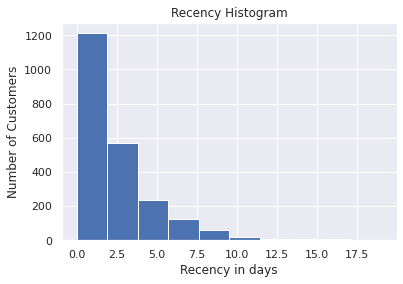

In [ ]:
# Plot Recency
customer.Recency.plot.hist();
plt.xlabel("Recency in days")
plt.ylabel("Number of Customers")
plt.title("Recency Histogram");

FREQUENCY SCORE

In [ ]:
# Count number of transaction per Customerid 
frequency = df.groupby('Customer_Id').Transaction_Date.count().reset_index()
frequency.columns = ['Customer_Id','Frequency']

# Consolidate Frequency to existing Customer DataFrame
customer = pd.merge(customer, frequency, on='Customer_Id')
customer.head()

,Customer_Id,Recency,Frequency
0,1680,8,446
1,1400,2,438
2,1681,3,469
3,1401,0,413
4,1402,1,410


In [ ]:
#Review statistics 
customer.describe()

,Customer_Id,Recency,Frequency
count,2240.000000,2240.000000,2240.000000
mean,1119.500000,2.083929,425.898214
std,646.776623,2.517489,19.922660
min,0.000000,0.000000,366.000000
25%,559.750000,0.000000,412.750000
50%,1119.500000,1.000000,426.000000
75%,1679.250000,3.000000,439.000000
max,2239.000000,19.000000,491.000000


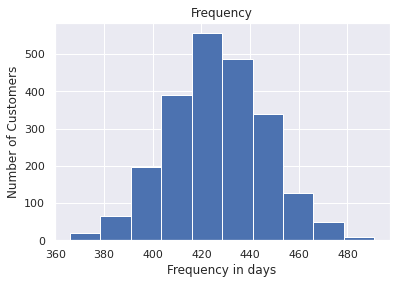

In [ ]:
# Plot Frequency
# In order to plot effectively and not have a skewed diagram, we've sorted the frequencies
customer.Frequency.sort_values().head(2240).plot.hist();
plt.xlabel("Frequency in days")
plt.ylabel("Number of Customers")
plt.title("Frequency");

# Monetary Value Score (Revenue)

In [ ]:
# Grouping revenue per Customer ID
revenue = df.groupby('Customer_Id').Amount_Spent.sum().reset_index().rename(columns = {'Amount_Spent': 'Monetary'}, inplace = False)

# Consolidate Revenue to existing Customer DataFrame
customer = pd.merge(customer, revenue, on='Customer_Id')
customer.head()

,Customer_Id,Recency,Frequency,Monetary
0,1680,8,446,286070
1,1400,2,438,292155
2,1681,3,469,332985
3,1401,0,413,297260
4,1402,1,410,278135


In [ ]:
customer.describe()

,Customer_Id,Recency,Frequency,Monetary
count,2240.000000,2240.000000,2240.000000,2240.000000
mean,1119.500000,2.083929,425.898214,282197.656250
std,646.776623,2.517489,19.922660,18313.471125
min,0.000000,0.000000,366.000000,226805.000000
25%,559.750000,0.000000,412.750000,269646.250000
50%,1119.500000,1.000000,426.000000,281530.000000
75%,1679.250000,3.000000,439.000000,294323.750000
max,2239.000000,19.000000,491.000000,349085.000000


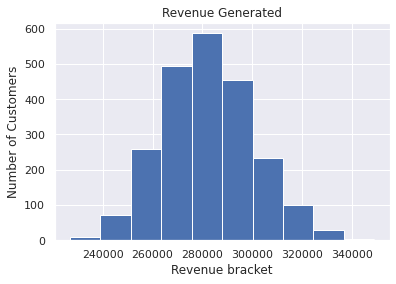

In [ ]:
# Plot Revenue
customer.Monetary.sort_values().head(2240).plot.hist();
plt.xlabel("Revenue bracket")
plt.ylabel("Number of Customers")
plt.title("Revenue Generated");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


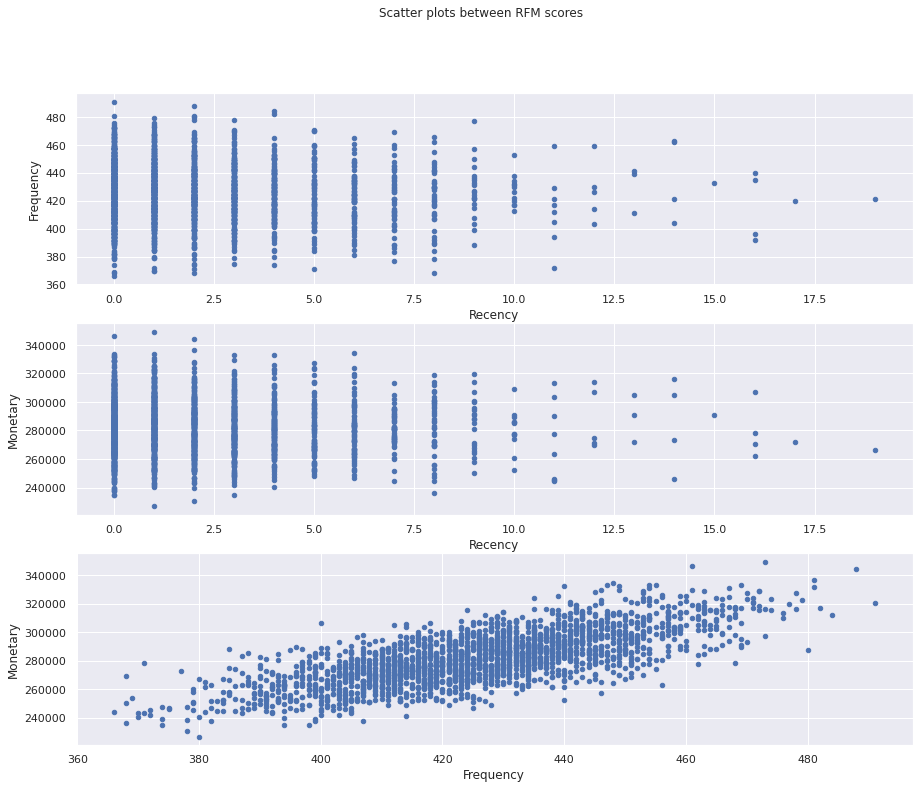

In [ ]:
# scatter plots between the different scores
fig, (xa1, xb2, xc3) = plt.subplots(3)
fig.suptitle('Scatter plots between RFM scores')
customer.plot.scatter(x = 'Recency', y = 'Frequency', ax = xa1, figsize = (15,12));
customer.plot.scatter(x = 'Recency', y = 'Monetary', ax = xb2);
customer.plot.scatter(x = 'Frequency', y = 'Monetary', ax = xc3);

Creating the RFM Segmentation Table

In [ ]:
def recency_quarter(x):

    recency_quantile = customer["Recency"].quantile([0.25, 0.50, 0.75]).values 
    if x <= recency_quantile[0]:
        return 1
    elif x <= recency_quantile[1]:
        return 2
    elif x <= recency_quantile[2]:
        return 3
    else:
        return 4

In [ ]:
def frequency_quarter(x):
    
    frequency_quantile = customer["Frequency"].quantile([0.25, 0.50, 0.75]).values 
    if x <= frequency_quantile[0]:
        return 1
    elif x <= frequency_quantile[1]:
        return 2
    elif x <= frequency_quantile[2]:
        return 3
    else:
        return 4

In [ ]:
def monetary_quarter(x):
    
    monetary_quantile = customer["Monetary"].quantile([0.25, 0.50, 0.75]).values 
    if x <= monetary_quantile[0]:
        return 1
    elif x <= monetary_quantile[1]:
        return 2
    elif x <= monetary_quantile[2]:
        return 3
    else:
        return 4

In [ ]:
#Scoring customers from 1 - 4 with functions
customer["RecencyScore"] = customer["Recency"].apply(recency_quarter)
customer["FrequencyScore"] = customer["Frequency"].apply(frequency_quarter)
customer["MonetaryScore"] = customer["Monetary"].apply(monetary_quarter)

customer.head()

,Customer_Id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
0,1680,8,446,286070,4,4,3
1,1400,2,438,292155,3,3,3
2,1681,3,469,332985,3,4,4
3,1401,0,413,297260,1,2,4
4,1402,1,410,278135,2,1,2


In [ ]:
customer["CombinedScore"] = customer["RecencyScore"].astype("str") + customer["FrequencyScore"].astype("str") + customer["MonetaryScore"].astype("str")
customer["CombinedScore"] = customer["CombinedScore"].astype("int")
print("Combined Score unique values:", customer["CombinedScore"].nunique())
customer["CombinedScore"].head()

Combined Score unique values: 63


0    443
1    333
2    344
3    124
4    212
Name: CombinedScore, dtype: int64

In [ ]:
customer["CombinedScoreTotal"] = customer["RecencyScore"] + customer["FrequencyScore"] + customer["MonetaryScore"]
customer["CombinedScoreTotal"] = customer["CombinedScoreTotal"].astype("int")
print("Combined Score Total unique values:", customer["CombinedScoreTotal"].nunique())
customer["CombinedScoreTotal"].head()

Combined Score Total unique values: 10


0    11
1     9
2    11
3     7
4     5
Name: CombinedScoreTotal, dtype: int64

In [ ]:
customer["CombinedScoreTotal"].value_counts()

7     353
9     326
6     318
8     309
5     244
10    225
4     169
11    132
3     106
12     58
Name: CombinedScoreTotal, dtype: int64

In [ ]:
customer.head()

,Customer_Id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,CombinedScore,CombinedScoreTotal
0,1680,8,446,286070,4,4,3,443,11
1,1400,2,438,292155,3,3,3,333,9
2,1681,3,469,332985,3,4,4,344,11
3,1401,0,413,297260,1,2,4,124,7
4,1402,1,410,278135,2,1,2,212,5


In [ ]:
# Count num of unique segments
rfm_count_unique = customer.groupby('CombinedScore')['CombinedScore'].nunique()
print(rfm_count_unique.sum())

63


In [ ]:
def rfm_labels(x):
    if x <= 4:
        return "Risk of churn"
    elif x <= 6:
        return "Low Spenders"
    elif x <= 8:
        return "Mid Spenders"
    else:
        return "High spenders"


In [ ]:
def rfm_labels(x):
    if x <= 4:
        return "Risk of churn"
    elif x <= 6:
        return "Low Spenders"
    elif x <= 8:
        return "Mid Spenders"
    else:
        return "High spenders"


In [ ]:
customer["levels"] = customer["CombinedScoreTotal"].apply(rfm_labels)
customer.head()

,Customer_Id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,CombinedScore,CombinedScoreTotal,levels
0,1680,8,446,286070,4,4,3,443,11,High spenders
1,1400,2,438,292155,3,3,3,333,9,High spenders
2,1681,3,469,332985,3,4,4,344,11,High spenders
3,1401,0,413,297260,1,2,4,124,7,Mid Spenders
4,1402,1,410,278135,2,1,2,212,5,Low Spenders


In [ ]:
customer.groupby("levels")["CombinedScoreTotal"].mean() # Average Combined Score of each segment

levels
High spenders    9.894737
Low Spenders     5.565836
Mid Spenders     7.466767
Risk of churn    3.614545
Name: CombinedScoreTotal, dtype: float64

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = customer.groupby('levels').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)


              Recency Frequency  Monetary      
                 mean      mean      mean count
levels                                         
High spenders     2.9     444.0  299282.4   741
Low Spenders      1.8     412.3  269117.7   562
Mid Spenders      2.1     426.7  282722.2   662
Risk of churn     0.2     402.9  261630.2   275


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



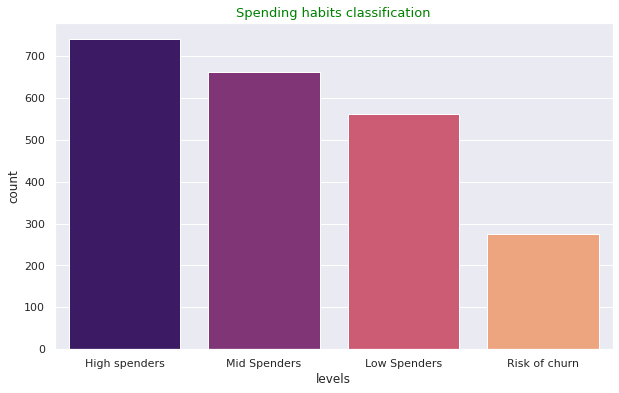

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Spending habits classification", c="green", size=13)
sns.countplot(customer["levels"], palette="magma");

In [ ]:
n_df = df.drop_duplicates('Customer_Id')
n_df.value_counts

<bound method DataFrame.value_counts of         Customer_Id  ... Transaction_Age
0              1680  ...            50.0
446            1400  ...            25.0
884            1681  ...            68.0
1353           1401  ...             8.0
1766           1402  ...            71.0
...             ...  ...             ...
951936          485  ...             4.0
952327          486  ...            35.0
952727          487  ...            62.0
953130          488  ...            94.0
953569          489  ...            32.0

[2240 rows x 30 columns]>

In [ ]:
new_customer_DF = customer.merge(n_df[['Customer_Id', 'Transaction_Age', 'Gender', 'State', 'Quantity_Purchased', 'Item_Price','Purchased_From', 'Holiday', 'Holiday_Name','Transaction_Month']], how='right', left_on='Customer_Id', right_on='Customer_Id')

In [ ]:
new_customer_DF.head(2)

,Customer_Id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,CombinedScore,CombinedScoreTotal,levels,Transaction_Age,Gender,State,Quantity_Purchased,Item_Price,Purchased_From,Holiday,Holiday_Name
0,1680,8,446,286070,4,4,3,443,11,High spenders,50.0,F,Mecklenburg-Vorpommern,7,100,online,No,None
1,1400,2,438,292155,3,3,3,333,9,High spenders,25.0,M,Baden-Württemberg,5,100,showroom,No,None


In [ ]:
# Calculate average age values for each RFM_Level, and return a size of each segment 
rfm_level_agg = new_customer_DF.groupby('levels').agg({
    'Transaction_Age': 'mean',})
# Print the aggregated dataset
print(rfm_level_agg)


               Transaction_Age
levels                        
High spenders        48.275304
Low Spenders         51.274021
Mid Spenders         52.089124
Risk of churn        51.545455


In [ ]:
# Calculate average quantity of items purchased for each RFM_Level, and return a size of each segment 
new_customer_DF.groupby("levels")["Quantity_Purchased"].mean()

levels
High spenders    5.404858
Low Spenders     5.460854
Mid Spenders     5.623867
Risk of churn    5.385455
Name: Quantity_Purchased, dtype: float64

In [ ]:
# Calculate average price of items purchased for each RFM_Level, and return a size of each segment 
new_customer_DF.groupby("levels")["Item_Price"].mean()

levels
High spenders    100
Low Spenders     100
Mid Spenders     100
Risk of churn    100
Name: Item_Price, dtype: int64

**DISTRIBUTION ANALYSIS OF OUR SEGMENTATION USING GENDER, STATE AND QUANTITY PURCHASED COLUMNS**

In [ ]:
gender_seg = new_customer_DF[['Customer_Id', 'levels', 'Gender']].groupby(['Customer_Id']).sum().reset_index()
gender_seg = gender_seg.sort_values('Customer_Id', ascending = False)
gender_seg

,Customer_Id,levels,Gender
2239,2239,Low Spenders,F
2238,2238,Low Spenders,M
2237,2237,Mid Spenders,M
2236,2236,Risk of churn,F
2235,2235,High spenders,F
...,...,...,...
4,4,High spenders,M
3,3,Mid Spenders,F
2,2,High spenders,F
1,1,Mid Spenders,F


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



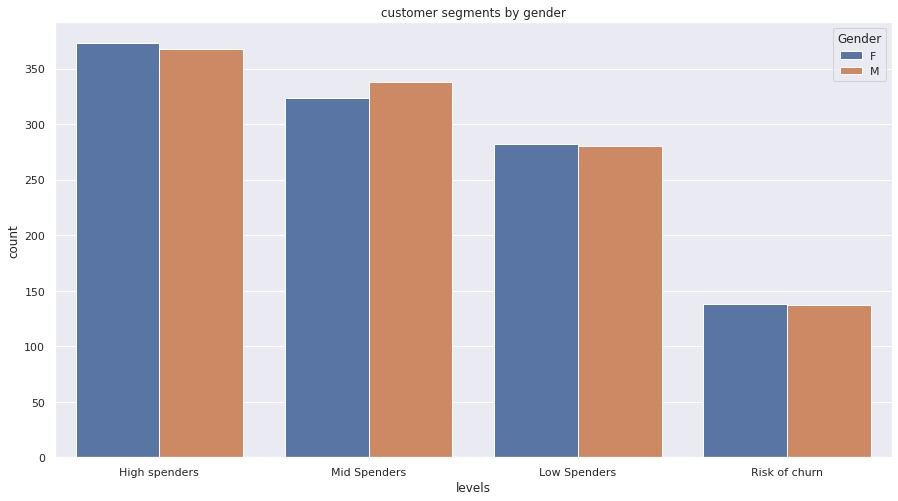

In [ ]:
# INSIGHTS ON CUSTOMER SEGMENTS BASED ON GENDER
plt.figure(figsize=(15, 8))
gender_seg = new_customer_DF[['Customer_Id', 'levels', 'Gender']].groupby(['Customer_Id']).sum().reset_index()
gender_seg = gender_seg.sort_values('Customer_Id', ascending = False)
plt.title('customer segments by gender')
sns.countplot(new_customer_DF['levels'],
hue = new_customer_DF.Gender)
plt.show()

In [ ]:
gender_seg = new_customer_DF[['Customer_Id', 'Gender']].groupby(['Customer_Id']).sum().reset_index()
gender_seg = gender_seg.sort_values('Gender', ascending = False)
gender_seg

,Customer_Id,Gender
1120,1120,M
921,921,M
1754,1754,M
941,941,M
1755,1755,M
...,...,...
963,963,F
960,960,F
959,959,F
958,958,F


**MORE INSIGHTS ON CUSTOMER SEGMENTS BASED ON STATES**

In [ ]:
# INSIGHTS ON CUSTOMER SEGMENTS BASED ON STATES
state_seg = new_customer_DF[['Customer_Id', 'levels', 'State']].groupby(['Customer_Id']).sum().reset_index()
state_seg = state_seg.sort_values('Customer_Id', ascending = False)
state_seg

,Customer_Id,levels,State
2239,2239,Low Spenders,Brandenburg
2238,2238,Low Spenders,Sachsen-Anhalt
2237,2237,Mid Spenders,Sachsen
2236,2236,Risk of churn,Hessen
2235,2235,High spenders,Niedersachsen
...,...,...,...
4,4,High spenders,Bayern
3,3,Mid Spenders,Thüringen
2,2,High spenders,Sachsen
1,1,Mid Spenders,Brandenburg


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



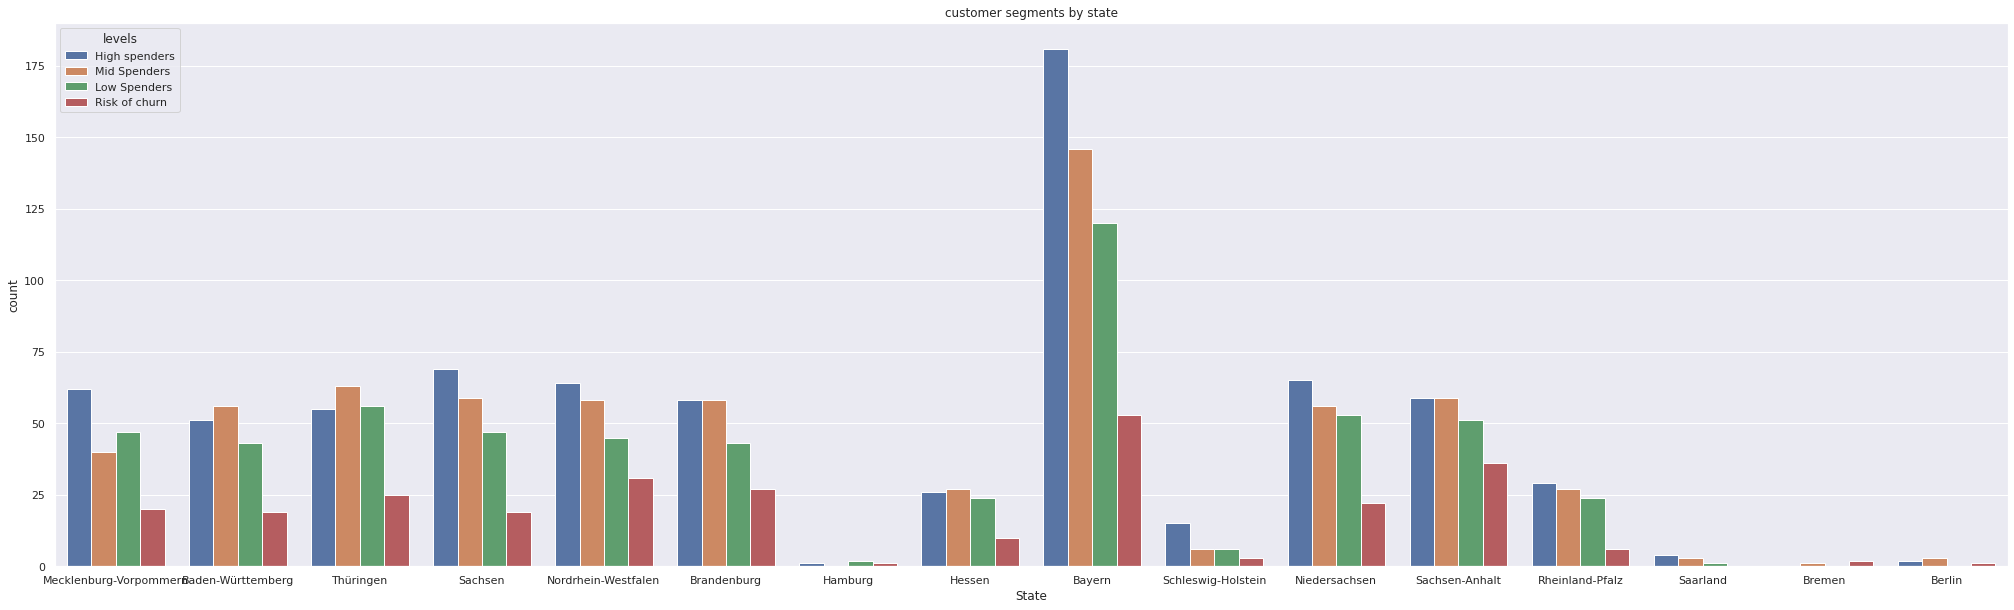

In [ ]:

plt.figure(figsize=(35, 10))
state_seg = new_customer_DF[['Customer_Id', 'levels', 'State']].groupby(['Customer_Id']).sum().reset_index()
state_seg = state_seg.sort_values('Customer_Id', ascending = False)
plt.title('customer segments by state')
sns.countplot(new_customer_DF['State'],
hue = new_customer_DF.levels)
plt.show()

**MORE INSIGHTS ON CUSTOMER SEGMENTS BASED ON TRANSACTION_AGE**

In [ ]:
quantity_seg = new_customer_DF[['Customer_Id', 'levels', 'Quantity_Purchased']].groupby(['levels']).sum().reset_index()
quantity_seg = quantity_seg.sort_values('Quantity_Purchased', ascending = False)
quantity_seg

,levels,Customer_Id,Quantity_Purchased
0,High spenders,820449,4005
2,Mid Spenders,757850,3723
1,Low Spenders,626771,3069
3,Risk of churn,302610,1481
